In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [3]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob

In [79]:
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

In [4]:
dmerge = datasets.get_data("pc")

PC_Dataset num_samples=91658 views=['PA'] data_aug=None


In [9]:
dmerge

{'Air Trapping': {0.0: 88285, 1.0: 3373},
 'Aortic Atheromatosis': {0.0: 90074, 1.0: 1584},
 'Aortic Elongation': {0.0: 84053, 1.0: 7605},
 'Atelectasis': {0.0: 87677, 1.0: 3981},
 'Bronchiectasis': {0.0: 90163, 1.0: 1495},
 'Cardiomegaly': {0.0: 83238, 1.0: 8420},
 'Consolidation': {0.0: 90661, 1.0: 997},
 'Costophrenic Angle Blunting': {0.0: 88178, 1.0: 3480},
 'Edema': {0.0: 91461, 1.0: 197},
 'Effusion': {0.0: 88316, 1.0: 3342},
 'Emphysema': {0.0: 90745, 1.0: 913},
 'Fibrosis': {0.0: 90985, 1.0: 673},
 'Flattened Diaphragm': {0.0: 91124, 1.0: 534},
 'Fracture': {0.0: 89051, 1.0: 2607},
 'Granuloma': {0.0: 89217, 1.0: 2441},
 'Hemidiaphragm Elevation': {0.0: 90294, 1.0: 1364},
 'Hernia': {0.0: 90177, 1.0: 1481},
 'Hilar Enlargement': {0.0: 87570, 1.0: 4088},
 'Infiltration': {0.0: 83915, 1.0: 7743},
 'Mass': {0.0: 90852, 1.0: 806},
 'Nodule': {0.0: 88001, 1.0: 3657},
 'Pleural_Thickening': {0.0: 88463, 1.0: 3195},
 'Pneumonia': {0.0: 88255, 1.0: 3403},
 'Pneumothorax': {0.0: 91435,

PC_Dataset num_samples=91658 views=['PA'] data_aug=None

In [5]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [6]:
models = [xrv.models.DenseNet(weights="all").cuda(),
          xrv.models.DenseNet(weights="mimic_ch").cuda(),
          xrv.baseline_models.jfhealthcare.DenseNet().cuda()]

In [7]:
model = models[0]
print(model.pathologies)
print(model)

['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-all


In [9]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [129]:
for_eval

['Cardiomegaly', 'Atelectasis', 'Effusion', 'Mass']

In [10]:
# target = "Effusion"
# label = 1
# dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == label))[0]
# dwhere[:10]

In [112]:
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
folder = "images/"
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"

In [169]:
for_eval = [
#             "Cardiomegaly", # 0.6
             "Atelectasis", # 0.6 + one extra
#             "Effusion", # 0.6
#             "Mass", # 0.6
#            "Lung Opacity", # 0.53
#            "Pneumothorax" # 0.53
            ]
pthresh = 0.6

In [166]:
# dmerge = datasets.get_data("siim")
# dmerge_large = datasets.get_data("siim", size=600)

dmerge = datasets.get_data("nih")
dmerge_large = datasets.get_data("nilarge", size=600)

# dmerge = datasets.get_data("rsna")
# dmerge_large = datasets.get_data("rsna", size=600)

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None


In [171]:
label = 1

for target in for_eval:
    print(target)
    num_to_generate = 20

    if not (target in dmerge.pathologies):
        continue

    dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == label))[0]

    if (dname == "nih") and (label == 1):
        dwhere = np.where(dmerge.csv.has_masks & (dmerge.labels[:,dmerge.pathologies.index(target)]  == 1))[0]
    print("num samples", len(dwhere))
    
    np.random.seed(0)
    for idx in np.random.choice(range(len(dwhere)), len(dwhere), replace=False):

        if num_to_generate == 0:
            break

        metadata = {}
        sample = dmerge[dwhere[idx]]

        if (dname == "nih") and (label == 1):
            # if path masks not available continue
            if not (dmerge.pathologies.index(target) in sample["pathology_masks"]):
                #print("no mask found")
                continue

        csv = dmerge.csv.iloc[dwhere[idx]]
        image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

        p = model(image)[:,model.pathologies.index(target)].detach().cpu()
        #print(p)

        if p > pthresh:    

            num_to_generate-= 1
            print("num_to_generate=", num_to_generate)

            #fname = csv.Path.str.replace("/","_").str.replace(".jpg","").max()
            try:
                uid = dwhere[idx].astype(str) + csv.patientid
            except:
                uid = dwhere[idx].astype(str)
                
            fid = dmerge.__class__.__name__ + "-" + uid + "-" + target + "-" + str(label)
            basefname = folder + fid

            json_name = basefname + ".json"
            if (os.path.exists(json_name)):
                print("already computed")
                continue

            metadata = {}
            metadata["id"] = fid
            metadata["idx"] = dwhere[idx].astype(str)
            metadata["dataset"] = dmerge.__class__.__name__
            metadata["source"] = json.loads(csv.to_json())
            metadata["target"] = target
            metadata["label"] = label
            metadata["model_used"] = str(model)
            metadata["pred"] = float(p.cpu().numpy())
            metadata["attribs"] = {}

            for i, method in enumerate(methods):
                
                px = 1/plt.rcParams['figure.dpi']
                full_frame(image_full[0].shape[0]*px,image_full[0].shape[1]*px)
                
                if method == "image":
                    image_full = dmerge_large[dwhere[idx]]["img"]
                    plt.imshow(image_full[0], interpolation='none', cmap="gray")
                else:
                    dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
                    plt.imshow(image_full[0], interpolation='none', cmap="gray")
                    dimage = skimage.transform.resize(dimage, image_full[0].shape, preserve_range=True, anti_aliasing=False, order=0)
                    dimage[dimage==0] = np.nan
                    plt.imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");

                rfname = basefname + "-" + method + '.png'
                print(rfname)
                metadata["attribs"][method] = rfname
                plt.savefig(rfname, bbox_inches='tight', pad_inches=0, transparent=False)
                plt.close()

            fname = attribution.generate_video(image, model, target, ae, temp_path, 
                                       target_filename=basefname + "-latentshift", 
                                       border=False, show=False)
            metadata["attribs"]["latentshift"] = basefname + "-latentshift.mp4"

            with open(json_name, 'w') as outfile:
                json.dump(metadata, outfile)

Atelectasis
num samples 166
num_to_generate= 19
images/NIH_Dataset-5755025228-Atelectasis-1-image.png
images/NIH_Dataset-5755025228-Atelectasis-1-grad.png
images/NIH_Dataset-5755025228-Atelectasis-1-guided.png
images/NIH_Dataset-5755025228-Atelectasis-1-integrated.png
[0.56391096] -1000 110
images/NIH_Dataset-5755025228-Atelectasis-1-latentshift-max.png
[0.56391096] -1000 110
0
10
20
module load ffmpeg;ffmpeg -loglevel quiet -stats -y -i /lscratch/joecohen/SDS-2342-ASDAA/image-%d-a.png -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'images/NIH_Dataset-5755025228-Atelectasis-1-latentshift.mp4'


AttributeError: module 'matplotlib.pyplot' has no attribute 'adasdas'

In [123]:
metadata = json.load(open(j))

In [128]:
metadata

{'id': 'images/CheXpert-v1.0-small_train_patient00009_study1_view1_frontal-Cardiomegaly-1',
 'source': {'index': 16,
  'Path': 'CheXpert-v1.0-small/train/patient00009/study1/view1_frontal.jpg',
  'Sex': 'Male',
  'Age': 76,
  'Frontal/Lateral': 'Frontal',
  'AP/PA': 'PA',
  'No Finding': None,
  'Enlarged Cardiomediastinum': None,
  'Cardiomegaly': 1.0,
  'Lung Opacity': None,
  'Lung Lesion': None,
  'Edema': 0.0,
  'Consolidation': None,
  'Pneumonia': None,
  'Atelectasis': 1.0,
  'Pneumothorax': None,
  'Pleural Effusion': None,
  'Pleural Other': None,
  'Fracture': None,
  'Support Devices': None,
  'view': 'PA',
  'patientid': '00009'},
 'target': 'Cardiomegaly',
 'label': 1,
 'model_used': 'XRV-DenseNet121-all',
 'pred': 0.8785651922225952,
 'attribs': {'image': 'images/CheXpert-v1.0-small_train_patient00009_study1_view1_frontal-Cardiomegaly-1-image.png',
  'grad': 'images/CheXpert-v1.0-small_train_patient00009_study1_view1_frontal-Cardiomegaly-1-grad.png',
  'guided': 'images/

In [43]:
dmerge = datasets.get_data("nih")
dmerge_large = datasets.get_data("nilarge", size=1000)

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None


In [44]:
target = "Cardiomegaly"
label = 1
dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == label))[0]
dwhere[:10]

array([ 0,  1,  2, 20, 35, 40, 43, 47, 48, 83])

In [45]:
print(target)
idx = 15
sample = dmerge[dwhere[idx]]
csv = dmerge.csv.iloc[[dwhere[idx]]]
image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()
image_full = dmerge_large[dwhere[idx]]["img"]

Cardiomegaly


In [372]:
# img = skimage.filters.gaussian(sample["img"][0], 
#                         mode='constant', 
#                         sigma=(2, 2), 
#                         truncate=3.5)
# image = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).cuda()
# image = (image-100).clamp(-1024, 1024)

In [36]:
model = models[0]

[0.35955217] -110 4
0
10
20
module load ffmpeg;ffmpeg -loglevel quiet -stats -y -i /lscratch/joecohen/SDS-2342-ASDAA/image-%d-a.png -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'


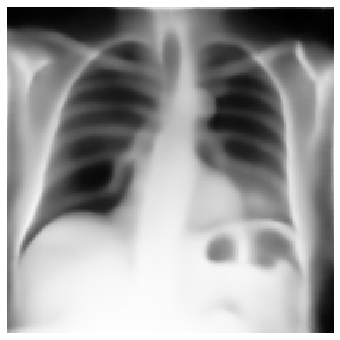

In [34]:
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"
attribution.generate_video(image, model, target, ae, temp_path, target_filename="test", border=False, show=True)

tensor([0.5829])


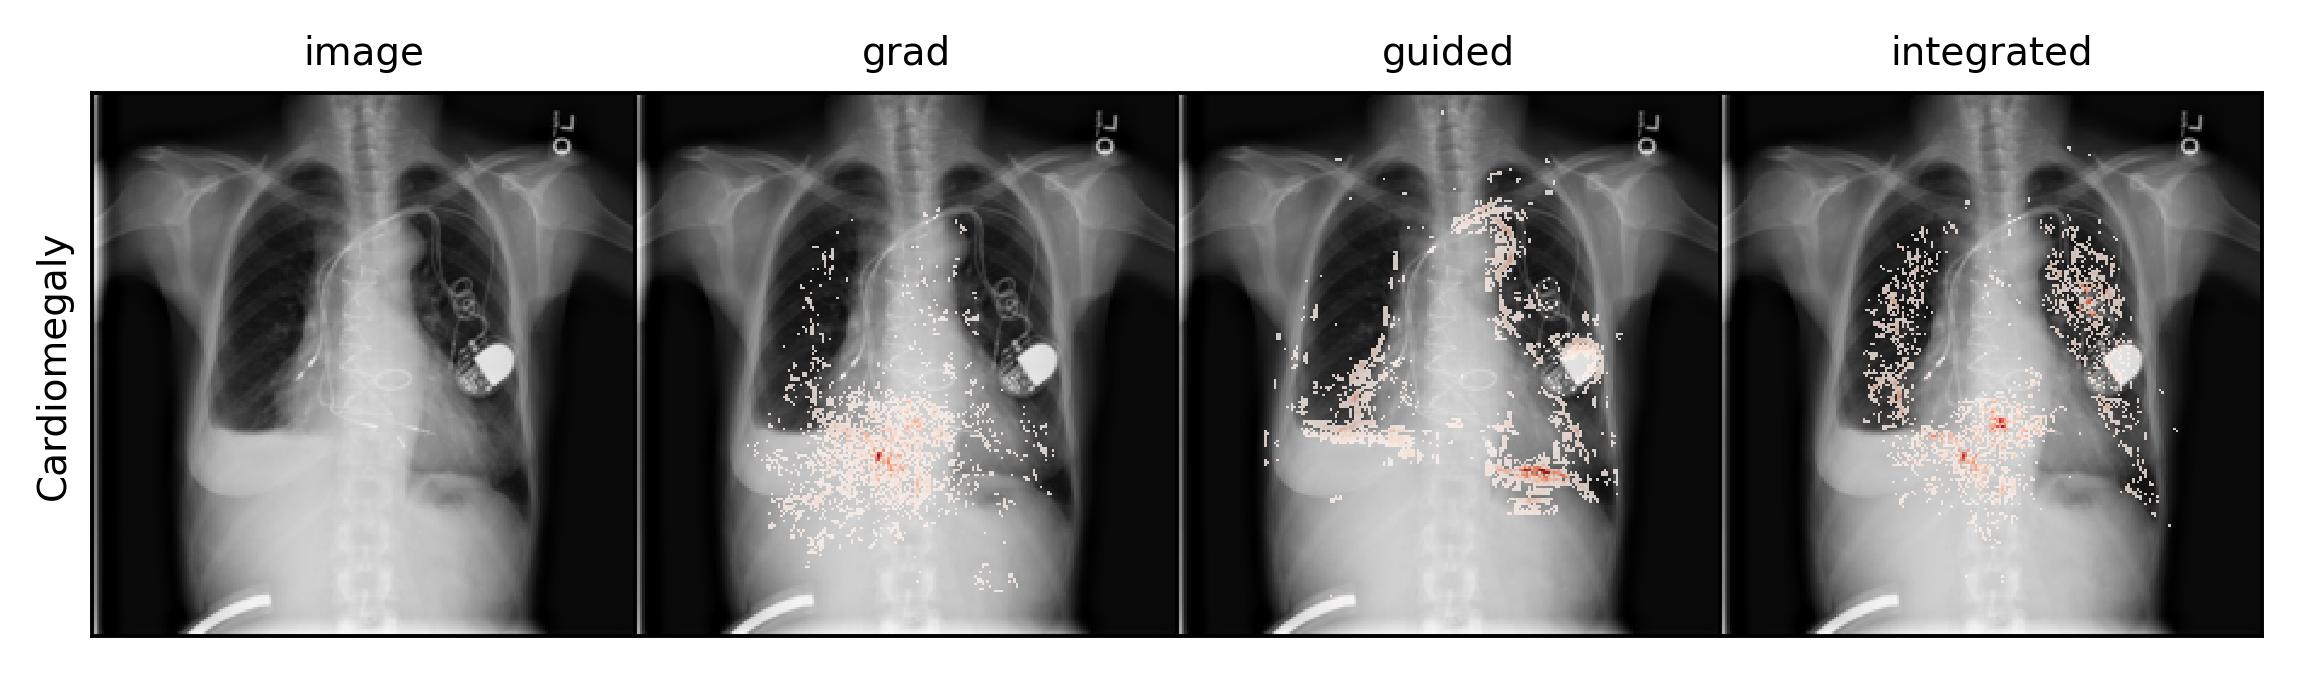

In [48]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);

tensor([0.5829])
[0.5147232] -80 50


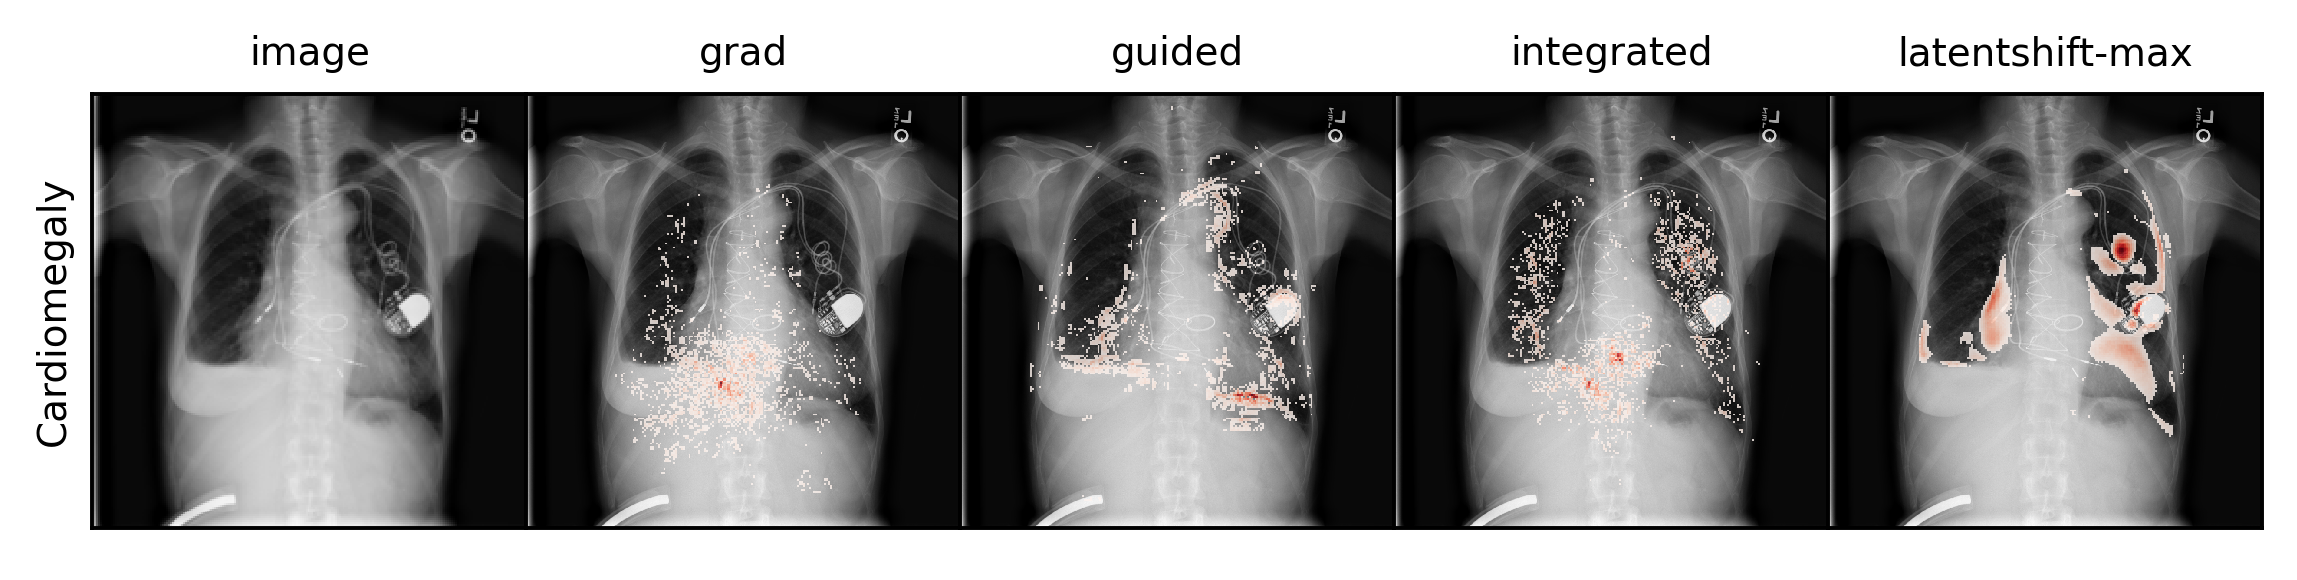

In [49]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated" ,"latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image_full[0], interpolation='none', cmap="gray")
        dimage = skimage.transform.resize(dimage, image_full[0].shape, preserve_range=True, anti_aliasing=False, order=0)
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);

tensor([0.6395])
[0.5017618] -1000 340


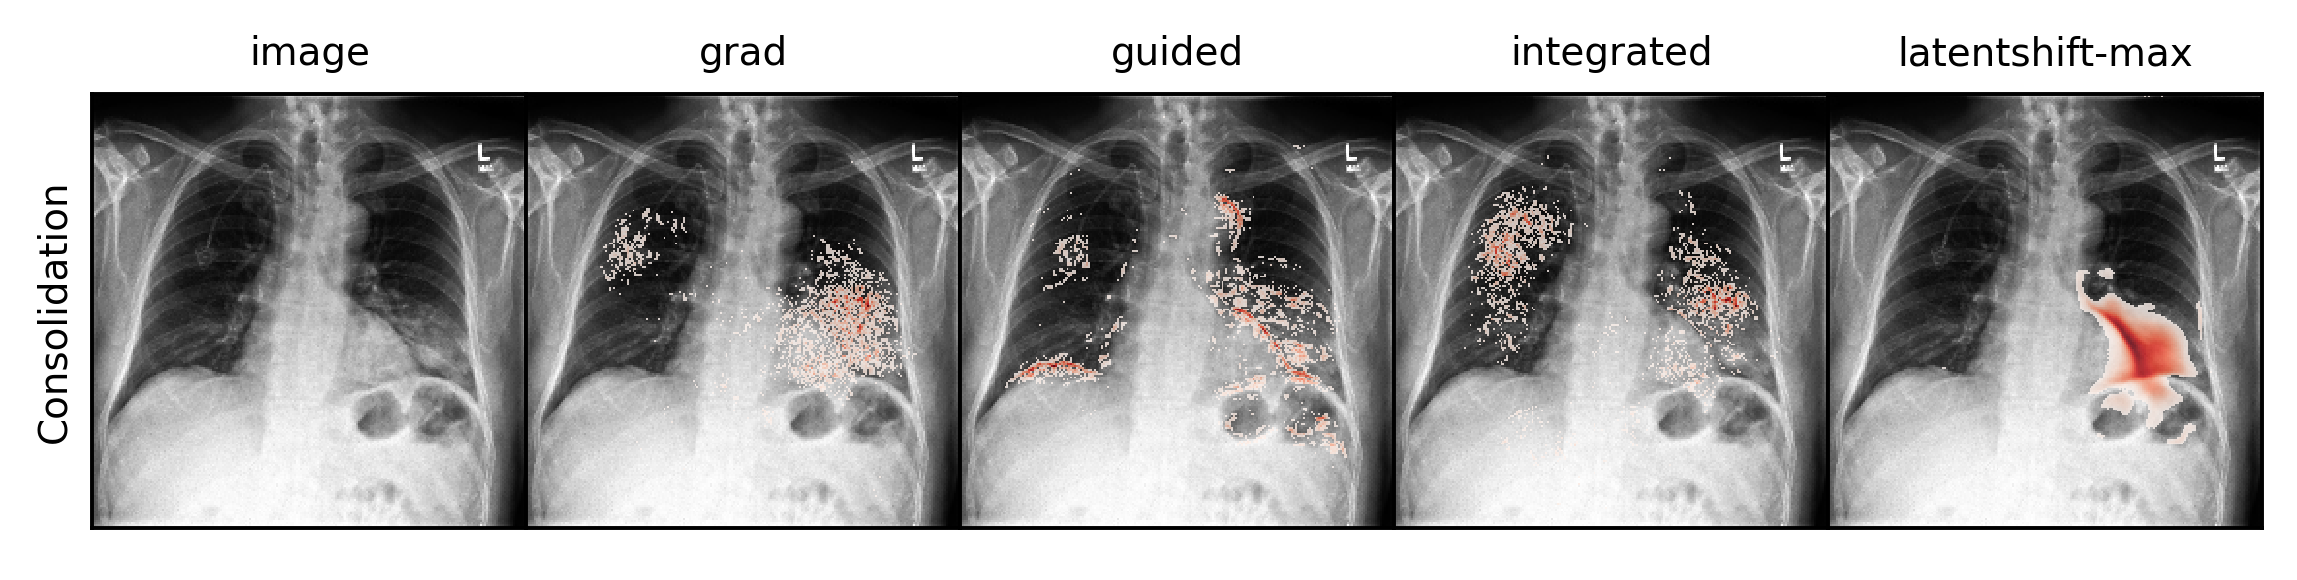

In [37]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);

tensor([0.8695])
[0.35955217] -110 4


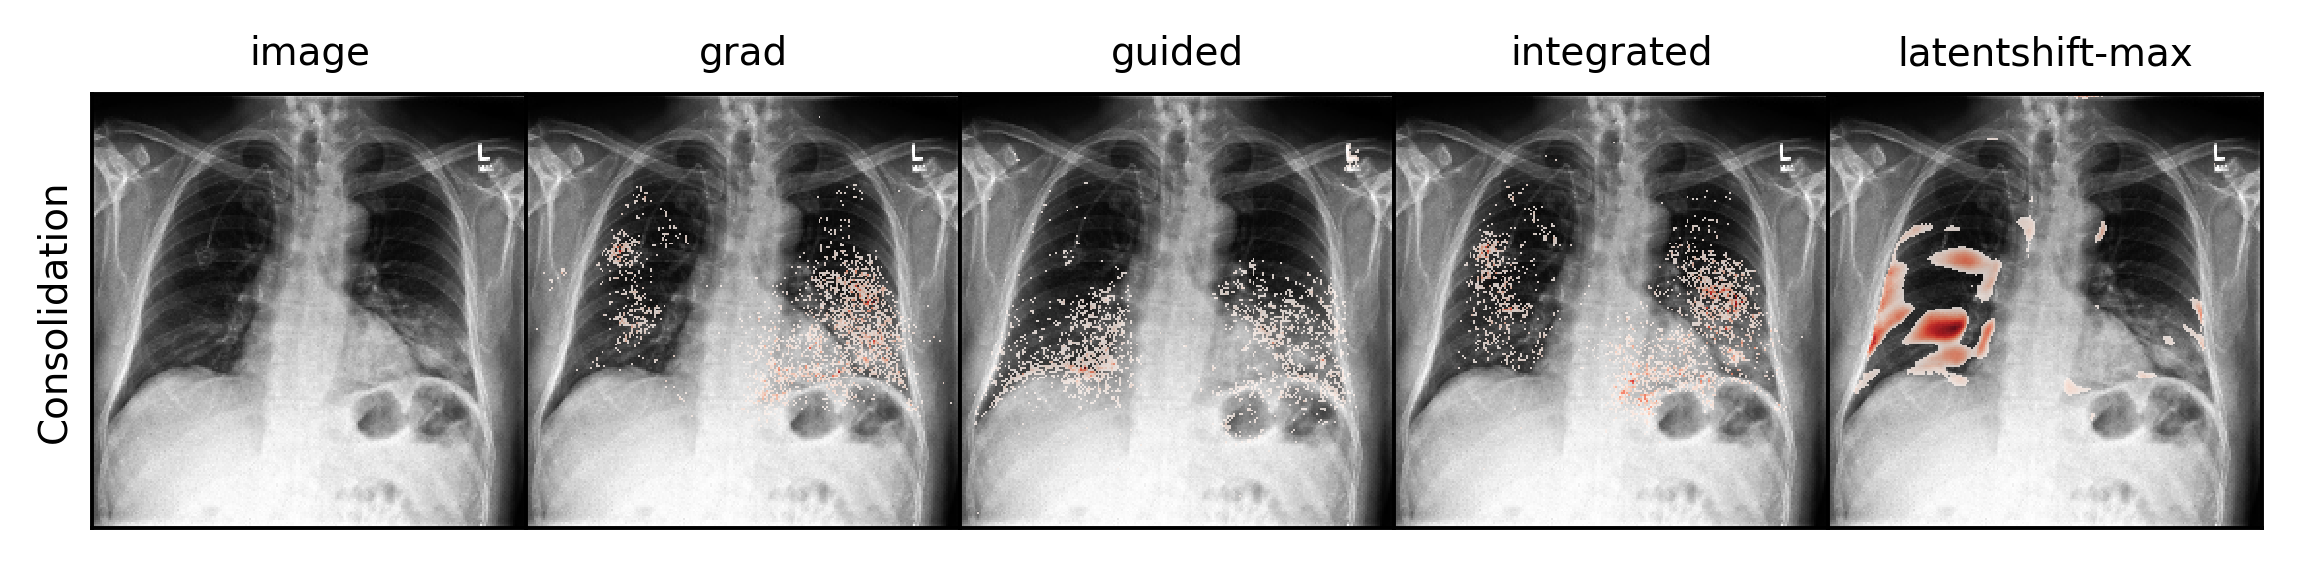

In [35]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);

tensor([0.8463])
[0.60260504] -150 10


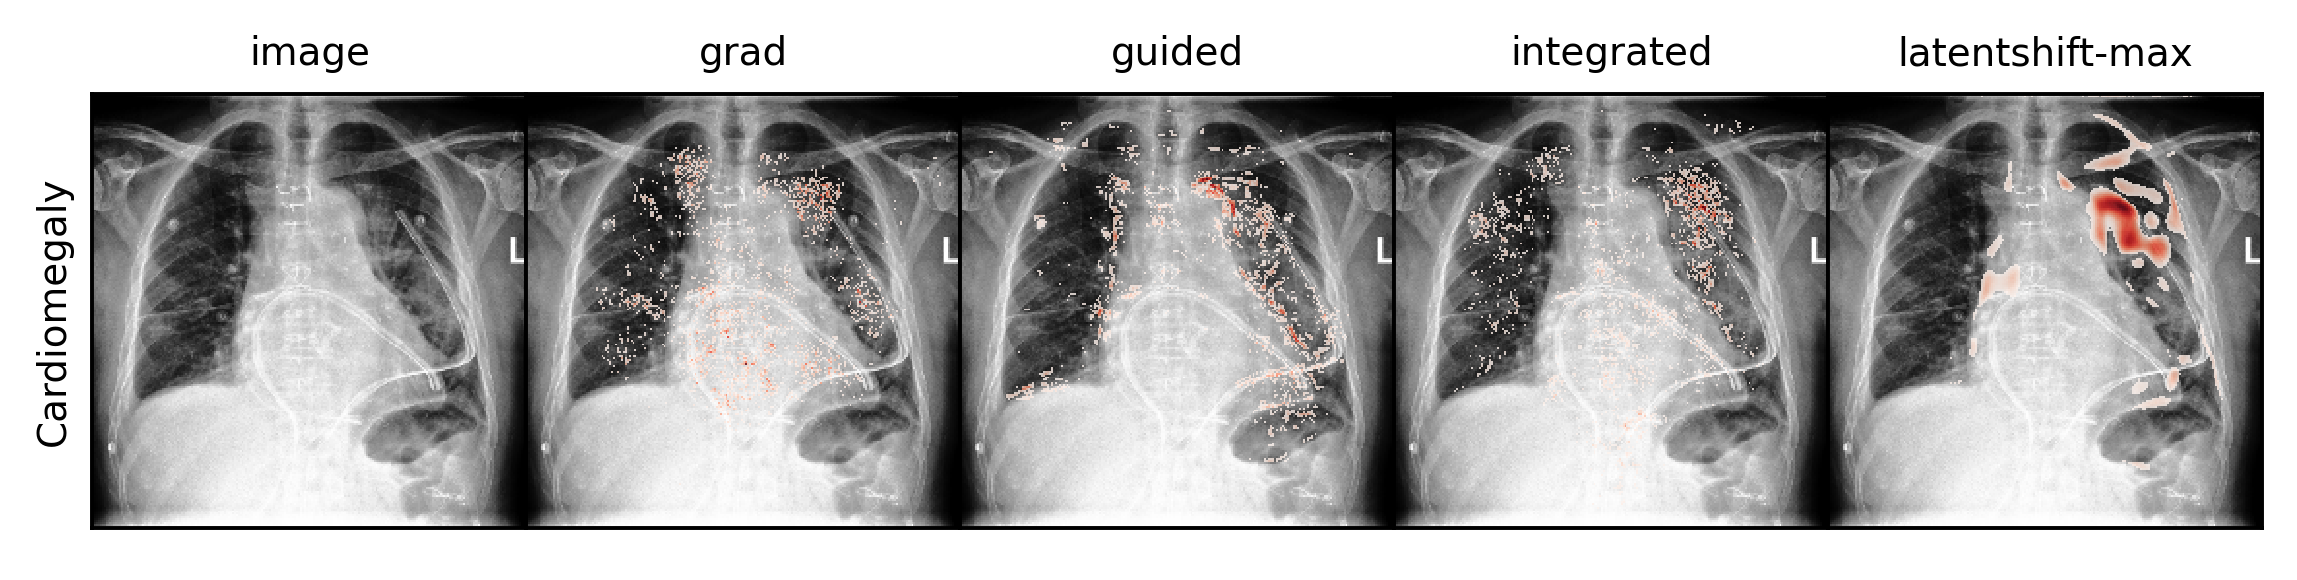

In [326]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);